# Week 2: Model Optimization, Regularization, and Hyperparameter Tuning

In [85]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.datasets import california_housing
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

(inputs, targets), (x_test, y_test) = california_housing.load_data(version='small',
                                                                   test_split=0.2)
print(inputs.shape, targets.shape)
print(x_test.shape, y_test.shape)

(480, 8) (480,)
(120, 8) (120,)


## Data Preprocessing

In [86]:
# Extract sets for training and validation
x_train = inputs[:380]
y_train = targets[:380]
x_val = inputs[380:]
y_val = targets[380:]

In [87]:
mean = x_train.mean(axis=0)  # mean and standard deviation computed from training set only
std = x_train.std(axis=0)
x_train -= mean
x_train /= std
x_test -= mean
x_test /= std
x_val -= mean
x_val /= std
y_train /= 1e5
y_test /= 1e5
y_val /= 1e5

## Model Optimization with Different Hyperparameters

I ran the model with various hyperparameters, repeating each test 10 times and averaging the test MAE to account for result variability.

When experimenting with different model architectures and hyperparameters while the training set and validation set were separated, I found out the following:

- Layers: 2 layers performed best; adding more reduced performance.
- Neurons per layer: 64 was optimal; below 40 or above 80 worsened results.
- Dropout: Best result with two dropout layers of 0.1 after each hidden layer.
- L2 Regularization: No regularization gave the best performance.
- Batch Normalization: Did not improve results.
- Learning Rate: Setting Adam's learning rate to 0.0005 improved performance.
- Early Stopping: Tested with different patience values, but it did not help.

When training the model with the full dataset, most of the hyperparameters tested above resulted in improved performance. This could be happening because the small dataset contains only 600 samples, which may not have been sufficient for the model to fully capture the underlying patterns.

In [88]:
#define the model architecture
model = Sequential([
    Input(shape=(8,)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),

    Dense(1)
])

#configure the learning algorithm
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse',metrics=['mae'])

In [89]:
history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_val, y_val), verbose=0)
test_loss, test_mae = model.evaluate(x_test, y_test)
print('Test MAE: ', test_mae)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.3102 - mae: 0.3196
Test MAE:  0.30885279178619385


Text(0, 0.5, 'Loss')

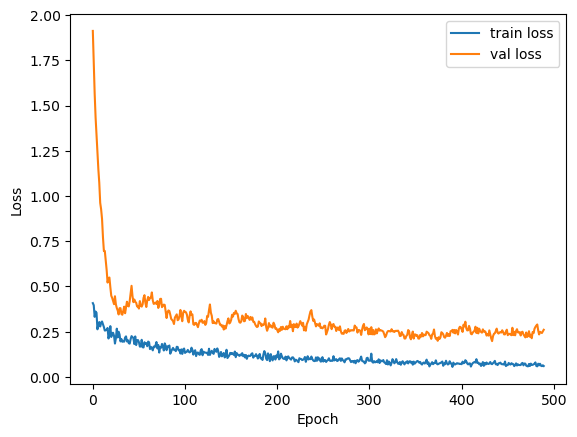

In [90]:
plt.plot(history.history['loss'][10:], label='train loss')
plt.plot(history.history['val_loss'][10:], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Mean absolute error (in 100000 $)')

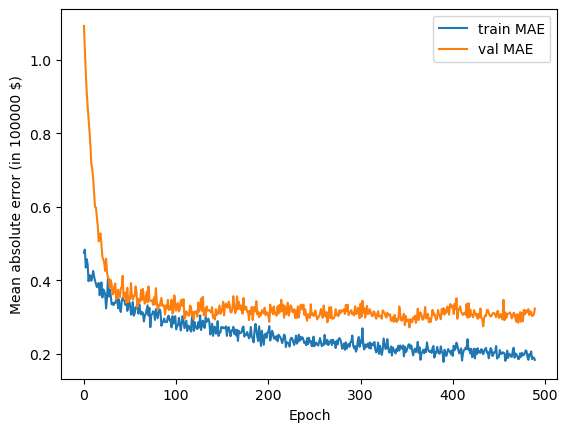

In [91]:
plt.plot(history.history['mae'][10:], label='train MAE')
plt.plot(history.history['val_mae'][10:], label='val MAE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean absolute error (in 100000 $)')

## Training the final model with the best hyperparameters and full dataset
Note that here we don't use validations split anymore since we are training the model with the full dataset. 

In [92]:
x_train_full = np.concatenate((x_train, x_val), axis=0) # join train + val sets
y_train_full = np.concatenate((y_train, y_val), axis=0)

model2 = Sequential([
    Input(shape=(8,)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),

    Dense(1)
])

model2.compile(optimizer=Adam(learning_rate=0.0005), loss='mse',metrics=['mae'])


model2.fit(x_train_full, y_train_full, epochs=500, batch_size=32, verbose=0)

test_loss2, test_mae2 = model2.evaluate(x_test, y_test)
print('Test MAE: ', test_mae2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.2720 - mae: 0.2906
Test MAE:  0.28227537870407104
